# Optimal map for Tanh with exact derivative and DNN

In [1]:
# import all relevant libraries
import torch
from torch import nn

import numpy as np
import sympy as sy
import mpmath as mp 

import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy import integrate
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
%matplotlib inline

## Miniminise interpolation error

k: degree of interpolating piecewise polynommials

m: Order of derivatives in the Hilbert space 0 <= m <= k

p: norm in Sobolev space

Choose k = 1, m = 0 and p = 2

Error bound is

|u - u_k|^2_L^2 <= C sum h_j^5 |u|^2_H^2  if u in H^2

For simplicity replace |u| by evaluating u directly at the midpoint of the interval h_j.

The output of the network must be the transformation map xi -> x.

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#device = 'cpu'
print(device)

cuda


## Define Multi-layer-perpeptron Network

In [ ]:
class softplus_power(torch.nn.Module):
    def __init(self):
        super.__init__()

    def forward(self, x):
        m = nn.Softplus()
        x = m(x)
        return x**1.1

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    
    # layers count the hiddens + the output 
    def __init__(self, layers, lb, ub):
        
        super().__init__()
        
        # parameters
        self.depth = len(layers) - 1
        self.lb = lb
        self.ub = ub
        self.activation = nn.LeakyReLU()
        
        # set up layer order dict
        self.layers = torch.nn.ModuleList()
        self.activations = torch.nn.ModuleList()
        
        for i in range(self.depth - 1): 
            self.layers.append(torch.nn.Linear(layers[i], layers[i+1]))
            self.activations.append(self.activation)
            
        self.layers.append(nn.Linear(layers[-2], layers[-1]))
    
                                     
    def forward(self, x):
        
        out = x
        for i in range(len(self.layers)-1):
            out = self.layers[i](out)
            out = self.activations[i](out)

        # out is of shape (ndata,1)
        out = self.layers[-1](out)
        out = rescale(out,self.lb,self.ub)    
        return out

In [5]:
def rescale(x,lb,ub):
    """ rescaling function to impose boundary conditions """           
    
    eps = 1e-5*torch.randn_like(x)
    x += eps 
    x = torch.sort(x)[0]
    # Avoid to have to equal coordinates, add a random eps to each variable 
    y = x - torch.min(x) 
    z = y.squeeze()/(torch.max(y).squeeze())
    z = lb + (ub - lb)*z
    
    return z 

## The Physics-Informed Neural Network

In [94]:
def init_weights(m):
    with torch.no_grad():
        
        if type(m) == torch.nn.Linear:
            m.weight.normal_(0, 0.01)
            m.bias.normal_(0, 0.01)

class PhysicsInformedNN():

    def __init__(self, N, xi, u, layers, lb, ub, k = 1, m = 0):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.N = N
        self.xi = torch.tensor(xi, requires_grad=True).float().to(device).unsqueeze(-1)
        self.layers = layers
        self.u = u 
        self.k = k
        self.m = m
        
        # neural net
        self.loss = []
        self.dnn = DNN(self.layers,self.lb,self.ub).to(device)
        
        # manual_seed works only with CUDA
        torch.manual_seed(1234)
        self.dnn.apply(init_weights)
        
        
        # optimizers: using the same settings
        #self.optimizer = torch.optim.RMSprop(self.dnn.parameters(),lr = 1e-5)
        
        ## works well when the first/second order derivative is computed analitycally
        #self.optimizer = torch.optim.Adadelta(self.dnn.parameters(),lr = 0.01)
        
        ## works well when the first/second order derivative is approximated
        self.optimizer = torch.optim.Adam(self.dnn.parameters(),lr = 0.01)
        self.iter = 0
    

    def avg_derivative(self,h,x):
        
        """ Compute first/second order derivative of u"""
                        
    
        ## compute analitycally the first derivative  ###
        #for i,v in enumerate(x):
        #   u[i] = 10*mp.sech(10*v)**2
        
        ## compute analitycally the second derivative ###
        #for i,v in enumerate(x):
        #    u[i] = -200*(mp.sech(10*v + 1e-6)**2)*np.tanh(10*v)
        X = x.detach().cpu().numpy()
        X = sorted(X)
        H = h.detach().cpu().numpy()
        H = sorted(H)

        f = lambda x : 800/3*(4 + np.cosh(20*x))*(mp.sech(10*x)**2)*np.tanh(10*x)**3

        res = np.zeros_like(H)
        for k,I in enumerate(H):
            res[k] = (1/(I+1e-6) *(f(X[k+1]) - f(X[k])))
        
        #print('res is: ', res)
        res = torch.tensor(res).float().to(device)
    
        return res
    
    def optimal_alpha(self,h,u_xx):
        
        Sum = torch.sum(h*u_xx**(1/(1+2*(self.k-self.m+1))))
        print('SUM is: ', Sum)
        alpha = torch.pow(1/(self.ub - self.lb)*Sum,1+2*(self.k-self.m+1))
       

        return alpha
        
    def net_equid(self,N,xi):
    
        x = self.dnn(xi)
        h = x.squeeze()
        h = torch.sort(h)[0]
        h = h[1:] - h[:-1]
        
        #u = self.u(10*x)
        u_xx = self.avg_derivative(h,x)
        #alpha = self.optimal_alpha(h,u_xx)
        alpha = 1
        f = h*torch.pow(1 + 1/alpha*u_xx,1/(1+2*(self.k-self.m+1)))
        f = torch.pow(f,1+2*(self.k-self.m+1))

        return f,alpha
    
    def loss_func(self):
        
        self.optimizer.zero_grad()
        f,alpha = self.net_equid(self.N,self.xi)
        Loss = ((self.N-1)**(2*(self.k-self.m+1)))*alpha*torch.sum(f)
        
        self.loss.append(Loss)
        Loss.backward()
        print('Iter %d, Loss: %.5e' % (self.iter, Loss.item()))
        return Loss
    
    def get_loss(self):
        return self.loss
    
    def train(self):  
        self.dnn.train()
        self.iter += 1   
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        
        relErr = 100
        if self.iter > 2:
            relErr = np.abs(self.loss[-1].item() - self.loss[-2].item())/(self.loss[-2].item())
        
        if relErr < 1e-6:
            return False
        else:
            return True
                     
    def predict(self, Xi):
        
        Xi = torch.tensor(Xi, requires_grad=True).float().unsqueeze(-1).to(device)
        self.dnn.eval()
        p = self.dnn(Xi)
        p = rescale(p,self.lb,self.ub)
        return p

In [95]:
# create uniform mesh with N points
N = 100
a = -1.0
b = 1.0

u = torch.tanh
xi = np.linspace(a,b,N)

# Training

In [96]:
# model parameters
layers = [1, 128, 128, 128, 128, 128, 128, 128, 1]
net = DNN(layers,a,b)

In [97]:
dic = net.state_dict()
for k in dic:
    dic[k] *= 0
net.load_state_dict(dic)
del(dic)

In [98]:
model = PhysicsInformedNN(N, xi, u, layers, a, b)

In [99]:
%%time

t = 1
it = 0
# define n_epochs and train for that epochs 
while t and it < 10000:
    t = model.train()
    it += 1

Iter 1, Loss: 2.84625e+05
Iter 2, Loss: 2.25417e+05
Iter 3, Loss: 3.58909e+06
Iter 4, Loss: 1.75586e+04
Iter 5, Loss: 9.69783e+03
Iter 6, Loss: 1.39094e+04
Iter 7, Loss: 1.62115e+04
Iter 8, Loss: 1.71175e+04
Iter 9, Loss: 1.33661e+04
Iter 10, Loss: 7.38349e+03
Iter 11, Loss: 3.28488e+03
Iter 12, Loss: 3.45977e+05
Iter 13, Loss: 1.51717e+04
Iter 14, Loss: 1.97738e+04
Iter 15, Loss: 2.21256e+04
Iter 16, Loss: 2.40059e+04
Iter 17, Loss: 2.57946e+04
Iter 18, Loss: 2.55010e+04
Iter 19, Loss: 2.50155e+04
Iter 20, Loss: 2.03451e+04
Iter 21, Loss: 1.75504e+04
Iter 22, Loss: 1.57193e+04
Iter 23, Loss: 1.39897e+04
Iter 24, Loss: 1.20663e+04
Iter 25, Loss: 1.11700e+04
Iter 26, Loss: 1.20587e+04
Iter 27, Loss: 1.24361e+04
Iter 28, Loss: 1.12184e+04
Iter 29, Loss: 9.55177e+03
Iter 30, Loss: 8.33318e+03
Iter 31, Loss: 7.71565e+03
Iter 32, Loss: 7.26108e+03
Iter 33, Loss: 7.01920e+03
Iter 34, Loss: 6.76643e+03
Iter 35, Loss: 6.45637e+03
Iter 36, Loss: 6.09188e+03
Iter 37, Loss: 5.77045e+03
Iter 38, L

In [100]:
LOSS = model.get_loss()

Text(0, 0.5, 'loss')

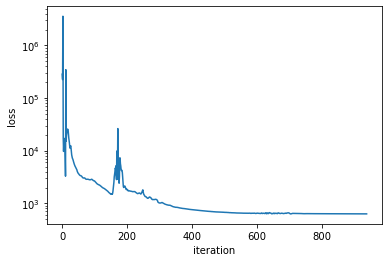

In [101]:
plt.semilogy(LOSS)
plt.xlabel('iteration')
plt.ylabel('loss')

### Visualise result

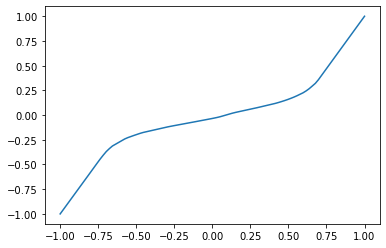

In [102]:
plt.plot(xi,model.predict(xi).detach().cpu().numpy())
plt.show()

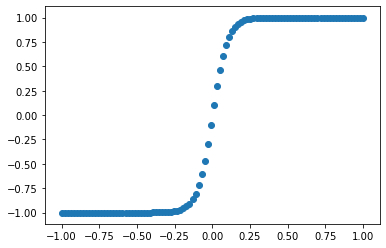

In [103]:
plt.scatter(xi,u(10*(torch.tensor(xi))).numpy())
plt.show()

In [104]:
N = 10000
a = -1
b = 1

si = np.linspace(a,b,N)
X = model.predict(si).detach().cpu().numpy()

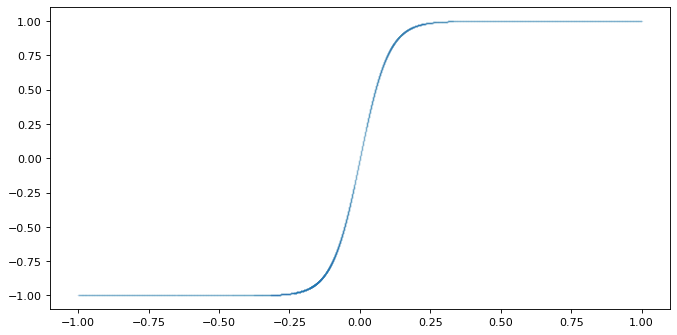

In [106]:
plt.figure(figsize=(10, 5), dpi=80)
plt.scatter(X,u(10*(torch.tensor(X))).numpy(),s =  1e-3)
plt.show()

## Convergence rate with piecewise linear interpolation

In [107]:
from scipy.interpolate import interp1d
import scipy.integrate as integrate

In [108]:
# evaluate L2 error between exact solution and linear interpolant 

In [109]:
def convRate(a,b,Nvec,equid=True):
    Errvec = np.zeros_like(Nvec)
    rate = np.zeros_like(Nvec[:-1])
    for i,N in enumerate(Nvec):
        x = np.linspace(a,b,N)
        if not equid:
            x = model.predict(x).detach().cpu().numpy()
        y = np.tanh(10*x)
        f_interp = interp1d(x,y)
        err = integrate.quad(lambda x: (np.tanh(10*x) - f_interp(x))**2,a,b)[0]
        Errvec[i] = np.sqrt(err)
        
    rate = np.log(Errvec[:-1]/Errvec[1:])/np.log(Nvec[1:]/Nvec[:-1])
    return rate,Errvec

In [112]:
Nvec = np.logspace(1.0,2.0,7)
rate_unif,Errvec_unif = convRate(a,b,Nvec)
rate,Errvec = convRate(a,b,Nvec,equid = False)


print(f"conv rate adapted mesh is {rate}")

conv rate adapted mesh is [1.93459324 2.29020093 2.13845196 2.0970527  2.07694303 2.10083066]


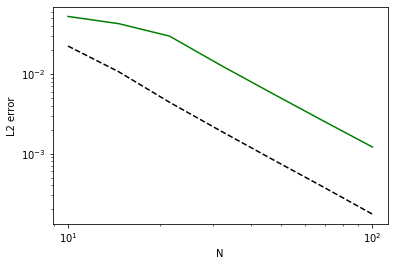

In [111]:
plt.loglog(Nvec,Errvec_unif,'g-')
plt.loglog(Nvec,Errvec,'k--')
plt.xlabel('N')
plt.ylabel('L2 error')
plt.show()